## Year by year analysis
The data for this project runs from 2000 to 2020. Before using this data though I need to check whether the data over the last 20 years is drawn from a similar distribution. It is not safe to just assume this as the nfl certainly evolves over time as new strategies are developed or players become more dynamic and fulfill different roles. Some examples: the rise of more dynamic quarterbacks such as Patrick Mahomes and Lamar Jackson who are able to throw as well as run with the ball exceptionally well, tight ends like Travis Kelce fulfilling more receiver roles, the increased importance of the passing game. My hypothesis is that these special players will serve as outliers at the current moment as football is still largely a slow changing game where people tend to stick with what has worked before and instead slowly adapt. Highly dynamic offenses such as the 2020 Chiefs team are more the outliers rather than the rule. The position that I expect to have the most variability is that of the QB where rushing has become much more important than in the past. I believe most of this data will be useful for training the model. The following notebook serves to determine whether this hypothesis is correct.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fantasy import stat_convs, fantasy_points, relevant_stats
from data_explore.data_help import plot_multiple_yearly_hists, player_stat_grouping, compare_splits, heatmap, auc_distance_scatter

In [13]:
# Read in saved player data
players_df = pd.read_csv('data/game_pro_ftb_ref_top_220.csv')
# Fill na stats to 0
players_df = players_df.drop('reason', axis=1).fillna(0).assign(reason=players_df['reason'])
# We're only concerned with games in which the players actually played enough to accrue
# some stats in this case as we are testing whether players performance across games has
# changed over the last twenty years
# Drop inactives
# players_df = players_df[players_df['reason'].isna()]

In [14]:
# Add fantasy point column
players_df['fantasy_points'] = fantasy_points(players_df)
# Group by 5 year intervals for visualization
players_df.loc[:, '5years'] = players_df.apply(lambda row: str(row.year // 5 * 5) + '-' + str(row.year // 5 * 5 + 4), axis=1)
# Assign an index for each game a player was in
stubs = players_df['stub'].unique()
for stub in stubs:
    player = players_df[players_df['stub'] == stub]
    players_df.at[player.index, 'career_game'] = range(len(player.index))

In [20]:
players_df[players_df['top_n']]

,full_name,pos,stub,year,game_date,game_num,week_num,age,team,game_location,...,xp_perc,fgm,fga,fg_perc,safety_md,unique_id,reason,fantasy_points,5years,career_game


### Quarterback

In [4]:
# Clean up QB data, drop games with less than 5 pass attempts these likely
# resulted from either being benched or an injury
qb_df = players_df[(players_df['pos'] == 'QB') & (players_df['pass_att'] > 5)].reset_index(drop=True)

/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not lay

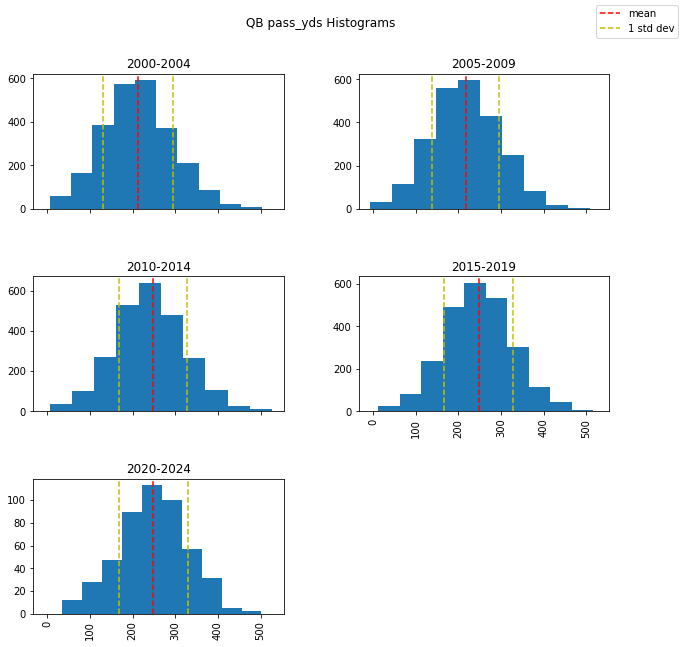

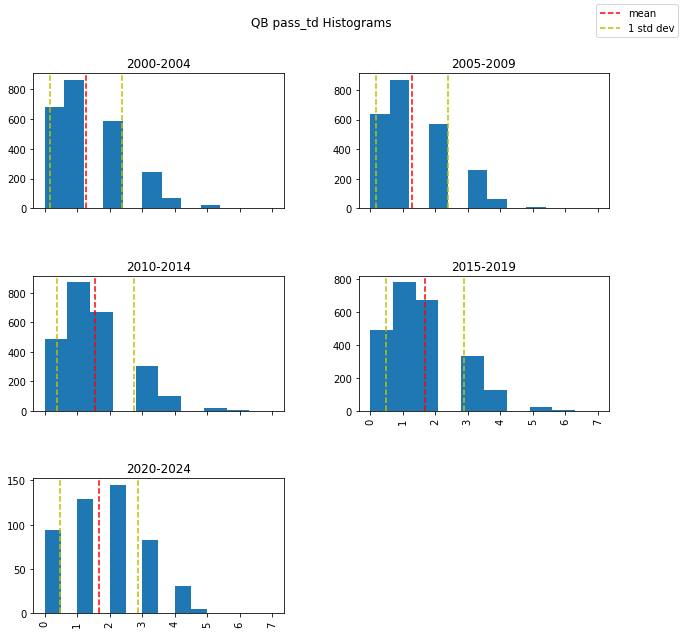

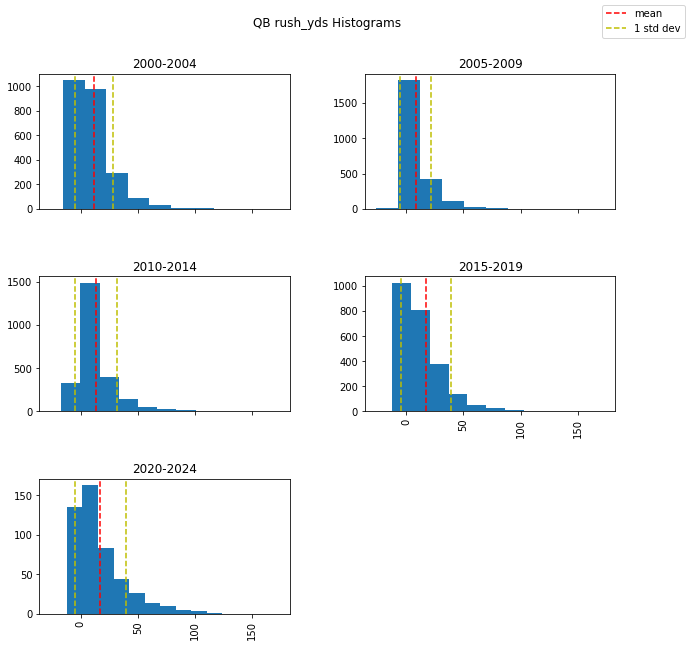

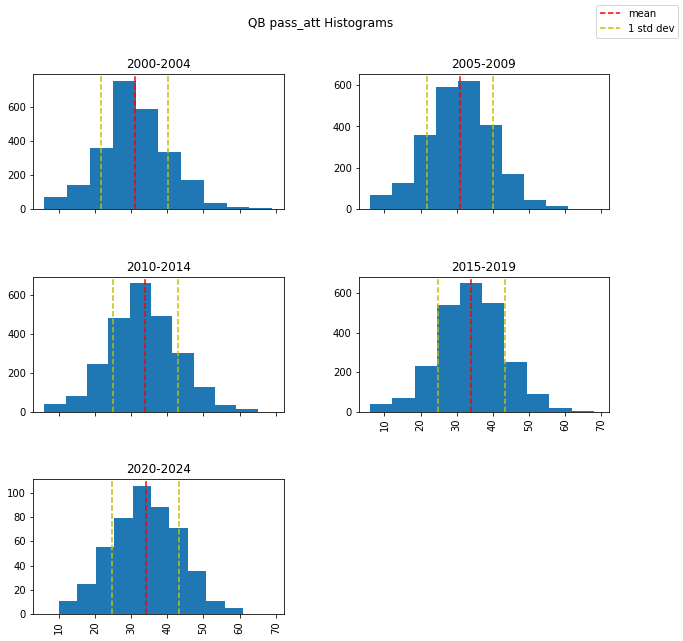

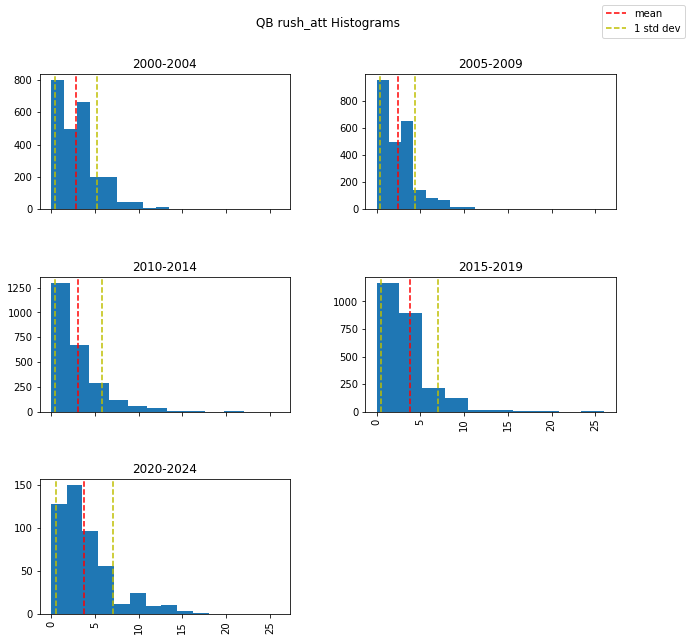

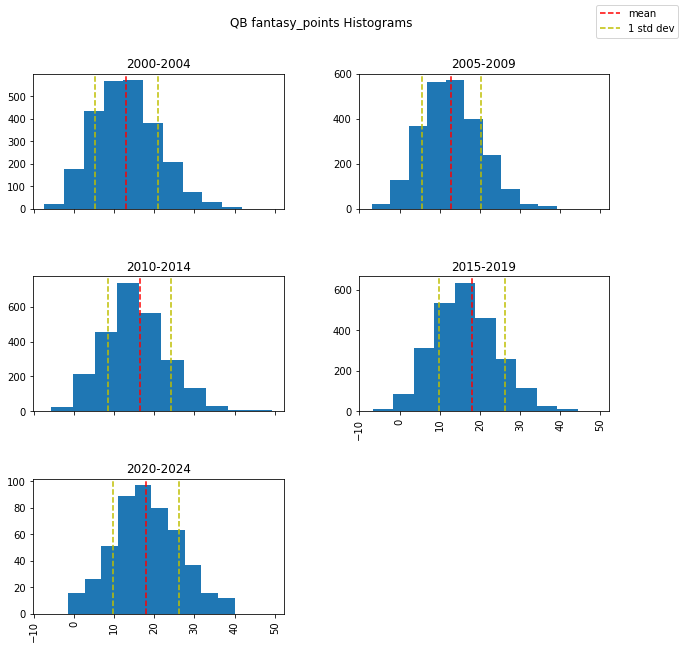

In [5]:
# First visualize data
plot_multiple_yearly_hists(qb_df, 'QB', ['pass_yds', 'pass_td', 'rush_yds', 'pass_att', 'rush_att', 'fantasy_points'],
                          histby='5years')

Visualizing the above statistics we can see that while many of the distributions are similarly shaped the mean in passing yards has increased over time while the passing attempts mean has largely stayed the same. This means that QBs have likely become more efficient over time which is not particularly surprising if you have watched the NFL for an extended period of time. Another thing of note is that while the rushing yards mean has not changed much over time, the std deviation bars have greatly increased in width. This is likely due to the fact (as mentioned before) that quarterbacks have become much more dynamic and quarterbacks like Lamar Jackson and Kyler Murray are becoming more frequent. While similar qbs like Michael Vick have existed in the past, they were much rarer then and served more as outliers rather than a trend. Before running more quantitative tests (i.e. statistical tests) to compare the similarity between these distributions, let's see how much these differences can be chalked up to outlier players. My hypothesis is that while the increased passing efficiency is likely a more general trend some of the rushing yards are likely due to some outstanding players such as Lamar Jackson. This is supported by the fact that the rushing attempt distribution has a much larger tail for 2020 which I am guessing is partly due to the Ravens using a very aggressive run first offense this past year. Let's now look at statistics grouped by player to identify any outliers.

In [6]:
player_means, player_stds = player_stat_grouping(qb_df, relevant_stats)
player_means = player_means.reset_index()
player_means.loc[:, 'pos'] = player_means.apply(lambda row: row.unique_id.split(',')[2], axis=1)
player_means.loc[:, 'year'] = player_means.apply(lambda row: int(row.unique_id.split(',')[3]), axis=1)
player_means.loc[:, '5years'] = player_means.apply(lambda row: str(row.year // 5 * 5) + '-' + str(row.year // 5 * 5 + 4), axis=1)

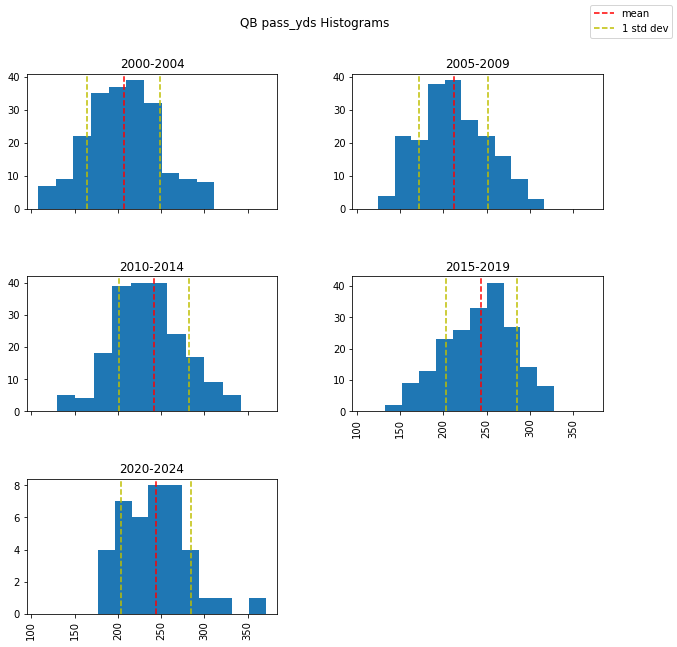

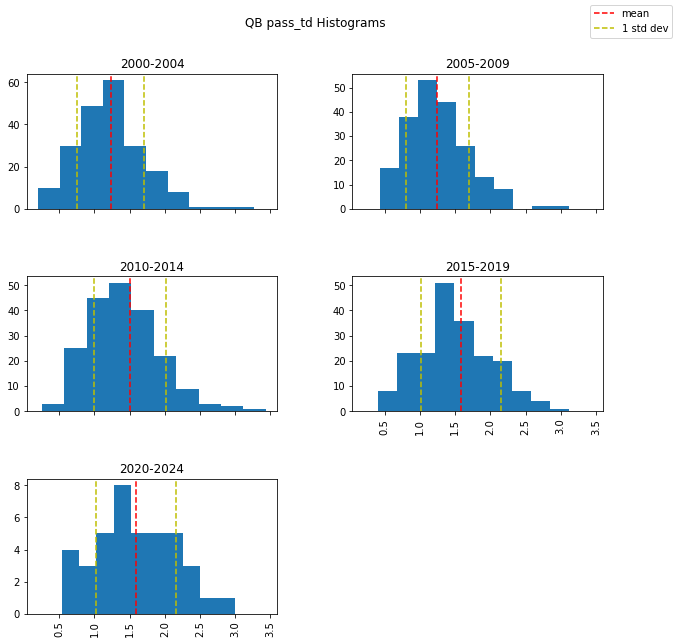

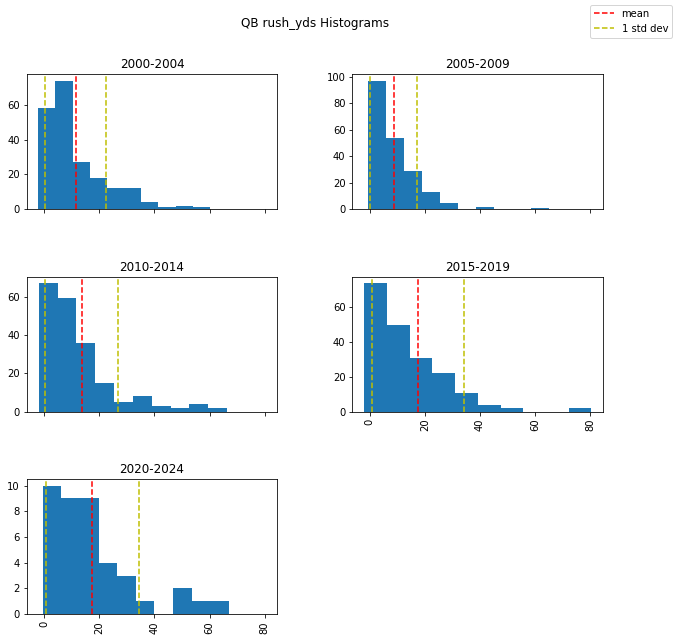

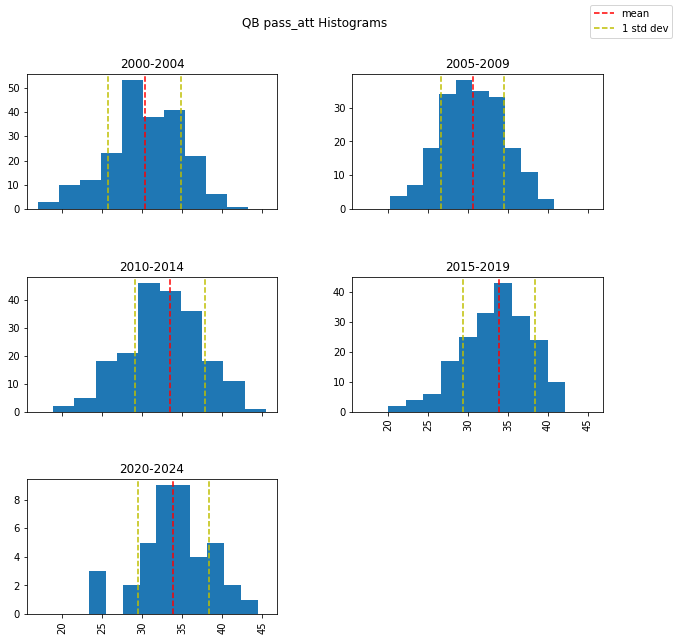

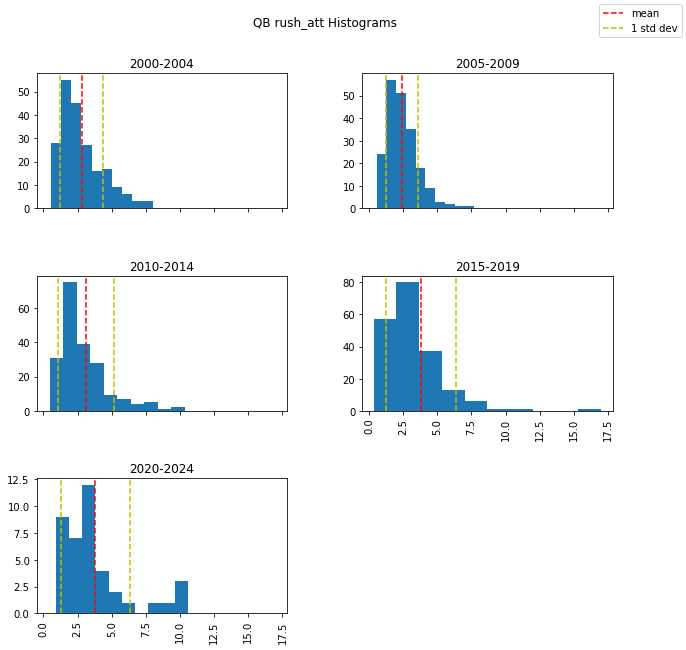

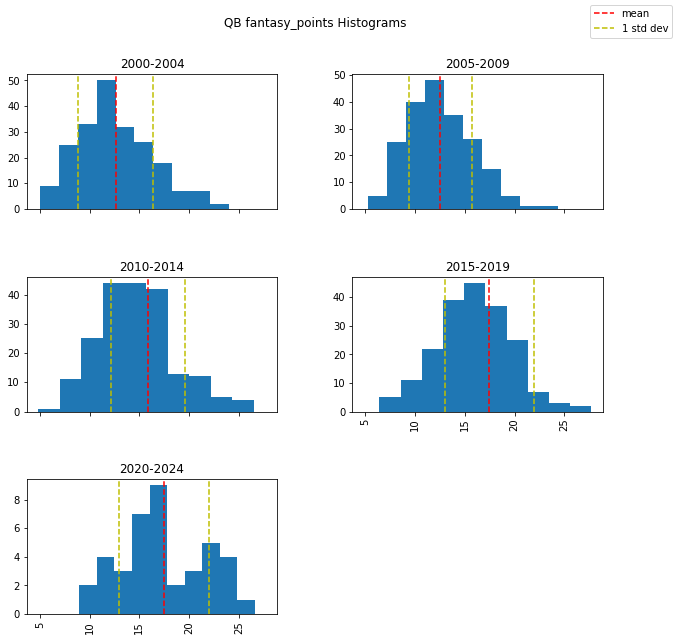

In [7]:
plot_multiple_yearly_hists(player_means, 'QB', ['pass_yds', 'pass_td', 'rush_yds', 'pass_att', 'rush_att', 'fantasy_points'],
                          histby='5years')

The above does confirm some of our hypothesis about rushing quarterbacks. In recent years more quarterbacks have seperated themselves from the rest of the pack and are exceptional runners. While they played in the past as well they were much less common. There is not much of note as far as passing yards go that hasn't been seen before. One noticeable trend though is that the as far as fantasy points go, quarterbacks have gotten much better in terms of points scored since 2000-2005 where the most elite quarterbacks have begun to separate themselves more from the bottom of the pack quarterbacks. Explaining this shift is beyond the scope of this project. This shift could potentially mean that using data from 2000-2010 could skew our model to produce a lower predicted score as it would affect our prior probability distribution. It could also be ok though as we are primarily concerned with our posterior distribution or the probability of getting a certain score given our input variables which will include past performance. My guess is that players posterior distribution given their previous performance will stay relatively constant over the years even if on average players have gotten better. Let's see if we can get an approximation of whether or not this is true.

One way we can see whether a covariate shift occurs between the 2000's and 2010's is to see whether a trained classifier is able to classify which decade a given data point belongs to (adopting technique from here: https://towardsdatascience.com/how-dis-similar-are-my-train-and-test-data-56af3923de9b). We'll try this a few different ways. First let's see what happens if I just pass in the stats for a single game by a player.

In [8]:
# Classifier
from sklearn.ensemble import RandomForestClassifier

In [9]:
years = np.array([year for year in range(2000, 2021)])

In [10]:
create_year_lambda = lambda year: (lambda df: df['year'] == year)
yearly_splits = [create_year_lambda(year) for year in years]
split_results_yearly = compare_splits(RandomForestClassifier(n_jobs=-1), qb_df, yearly_splits, input_vars=relevant_stats)

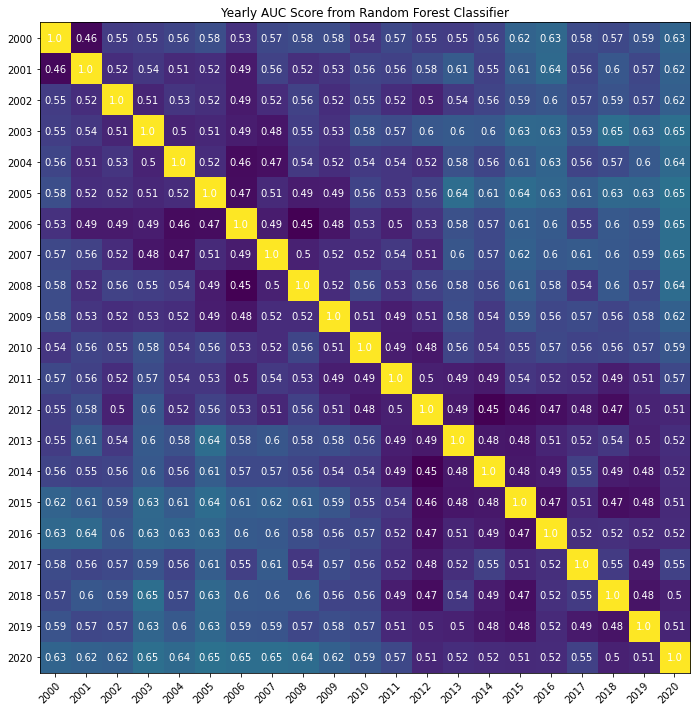

In [11]:
heatmap(split_results_yearly, years, years, 'Yearly AUC Score from Random Forest Classifier')

In [12]:
def auc_distance_scatter(splits, title):
    # Plot how distance changes 
    results = [[] for dist in range(splits.shape[0])]
    for i in range(splits.shape[0]):
        for j in range(splits.shape[1]):
            if i >= j:
                continue
            distance = abs(i - j)
            results[distance].append(splits[i][j])
    
    means = [np.mean(result) for result in results]
    print(means)
    xs = []
    ys = []
    for i, dist in enumerate(results):
        for y in dist:
            ys.append(y)
            xs.append(i)
            
    plt.scatter(xs, ys)
    plt.plot(range(len(means)), means, color='r')
    plt.xlabel('Distance between Years')
    plt.ylabel('AUC Score')
    plt.ylim(bottom=0, top=1)
    plt.xticks([x for x in range(splits.shape[0])])
    plt.title(title)
    plt.show()

/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan, 0.498112253158557, 0.5027727073496376, 0.5106313815517566, 0.5197500001097087, 0.5272823807457203, 0.5395431363280114, 0.5497379471471545, 0.563873559744869, 0.5750352783437415, 0.5810948716879104, 0.5855771836525306, 0.6029111470767464, 0.5943875858543473, 0.6014465785516181, 0.6221876119998523, 0.6102621796756668, 0.5983487425550441, 0.5826791585234417, 0.6044929223716242, 0.6251129363449692]


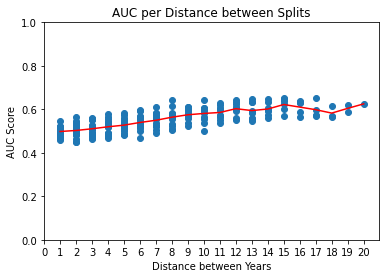

In [13]:
auc_distance_scatter(split_results_yearly, 'AUC per Distance between Splits')

From the above we can see that as years become further apart, the model has an easier time predicting which year the game belongs in. This demonstrates that for quarterbacks later years differ more noticeably from past years. Let's see if it can predict a player's year given their average stats over a year.

In [14]:
player_split_results_yearly = compare_splits(RandomForestClassifier(n_jobs=-1), player_means, yearly_splits, input_vars=relevant_stats)

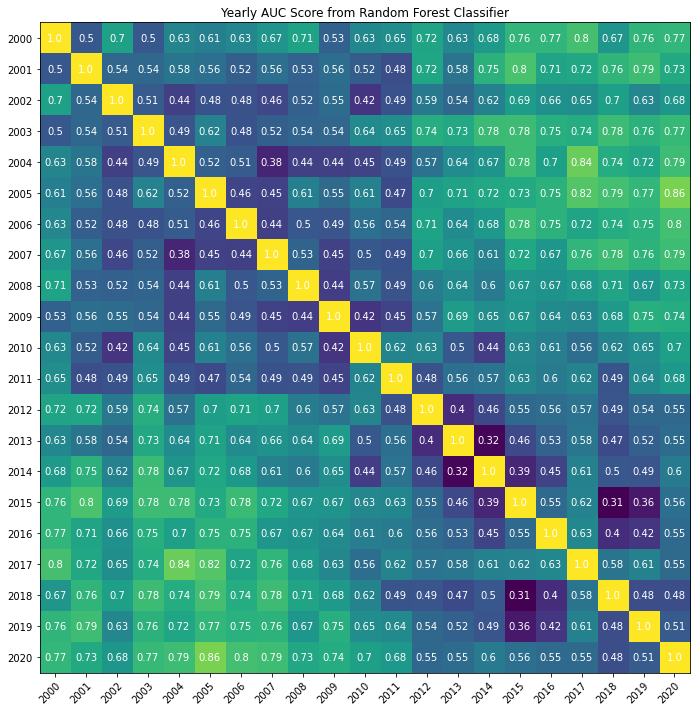

In [15]:
heatmap(player_split_results_yearly, years, years, 'Yearly AUC Score from Random Forest Classifier')

/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan, 0.49091225488634355, 0.5221294857774152, 0.5085135858609786, 0.5374645169142018, 0.5650086430313108, 0.5776899469053444, 0.5927619917022886, 0.6247565914593249, 0.6486648635359108, 0.683071244947122, 0.7143801306860015, 0.714562818576763, 0.7500176530528595, 0.7407954463647883, 0.7485830104845973, 0.7461501119724804, 0.7408063236106, 0.7118895886439747, 0.7453326023391813, 0.7675000000000002]


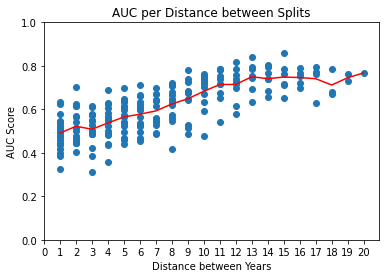

In [16]:
auc_distance_scatter(player_split_results_yearly, 'AUC per Distance between Splits')

This is even more notable as the model has an easy time predicting what year a player belongs to even with a small sample size of ~32 per year. There is considerably more noise here though as a result, as evidenced by the tests (i.e. 2018 vs 2016) which perform worse than random chance so this may be a bit less trustworthy.

In [17]:
five_years = np.unique((years // 5) * 5)

In [18]:
create_five_year_lambda = lambda five_year: (lambda df: (df['year'] // 5) * 5 == five_year)
five_yearly_splits = [create_five_year_lambda(five_year) for five_year in five_years]
split_results_five_yearly = compare_splits(RandomForestClassifier(n_jobs=-1), qb_df, five_yearly_splits, input_vars=relevant_stats)

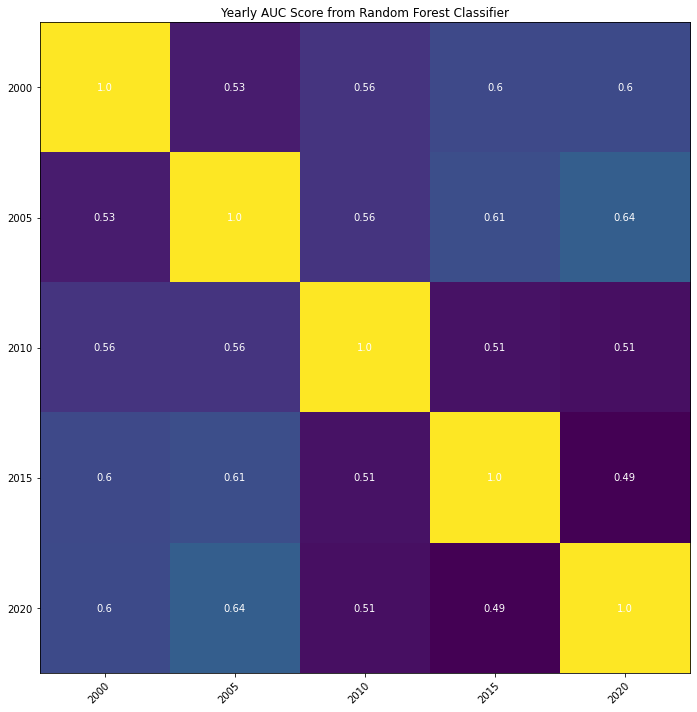

In [19]:
heatmap(split_results_five_yearly, five_years, five_years, 'Yearly AUC Score from Random Forest Classifier')

[nan, 0.5212303248390636, 0.5595342459161866, 0.6186628341149498, 0.6009418982616865]


/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


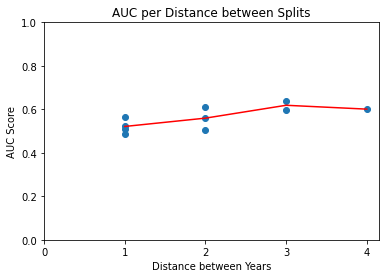

In [20]:
auc_distance_scatter(split_results_five_yearly, 'AUC per Distance between Splits')

In [21]:
player_split_results_five_yearly = compare_splits(RandomForestClassifier(n_jobs=-1), player_means, five_yearly_splits, input_vars=relevant_stats)

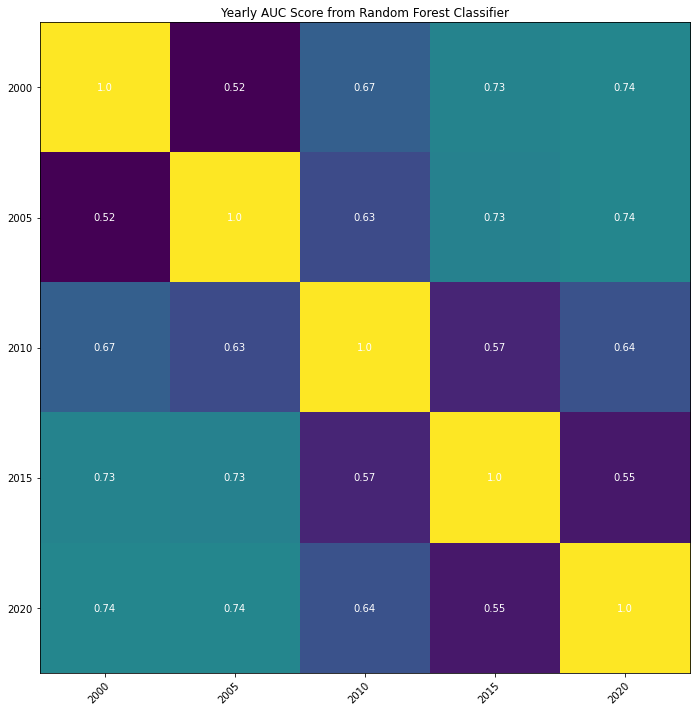

In [22]:
heatmap(player_split_results_five_yearly, five_years, five_years, 'Yearly AUC Score from Random Forest Classifier')

[nan, 0.5683247746464031, 0.6791363949707568, 0.7381218662570362, 0.7400717703349282]


/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


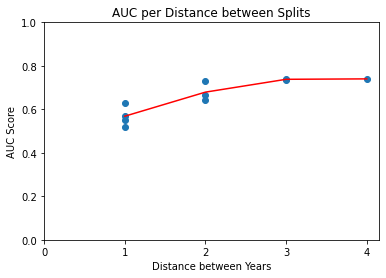

In [23]:
auc_distance_scatter(player_split_results_five_yearly, 'AUC per Distance between Splits')

This distinction between the different time periods is something to keep in mind although I won't be removing the earlier years from the dataset by default.

### Wide Receiver

In [24]:
# Grab wr data
wr_df = players_df[(players_df['pos'] == 'WR')].reset_index(drop=True)

/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not lay

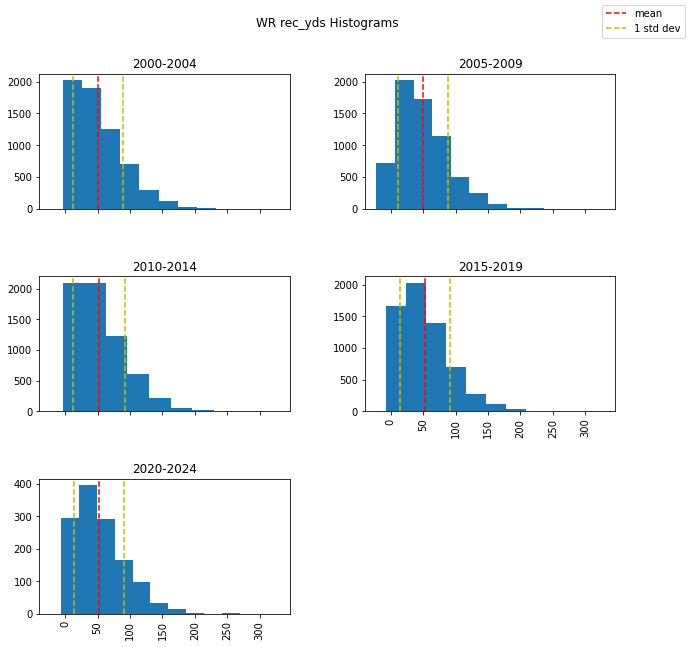

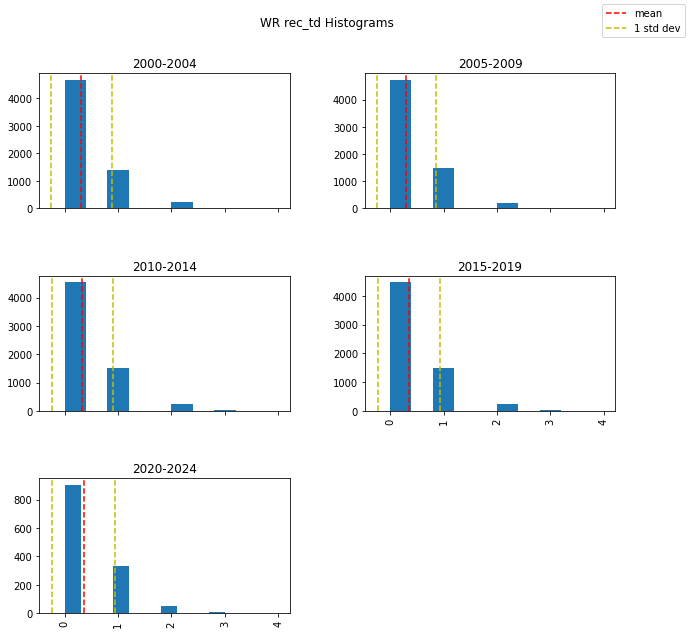

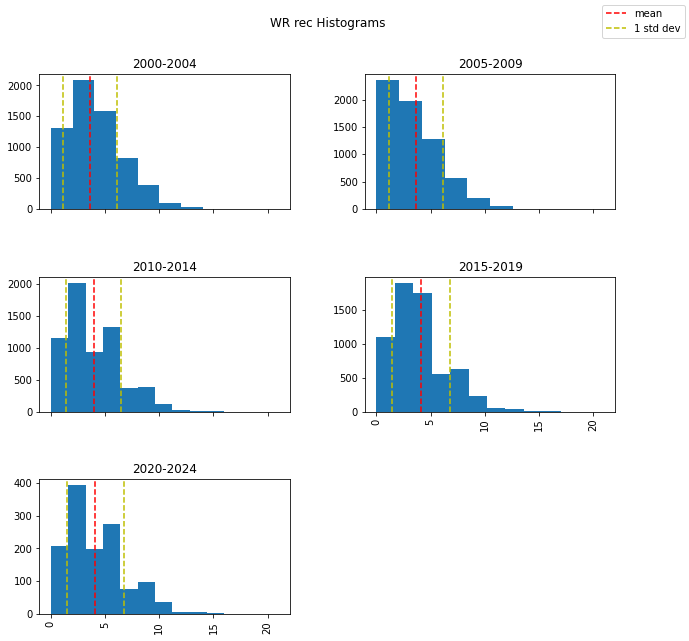

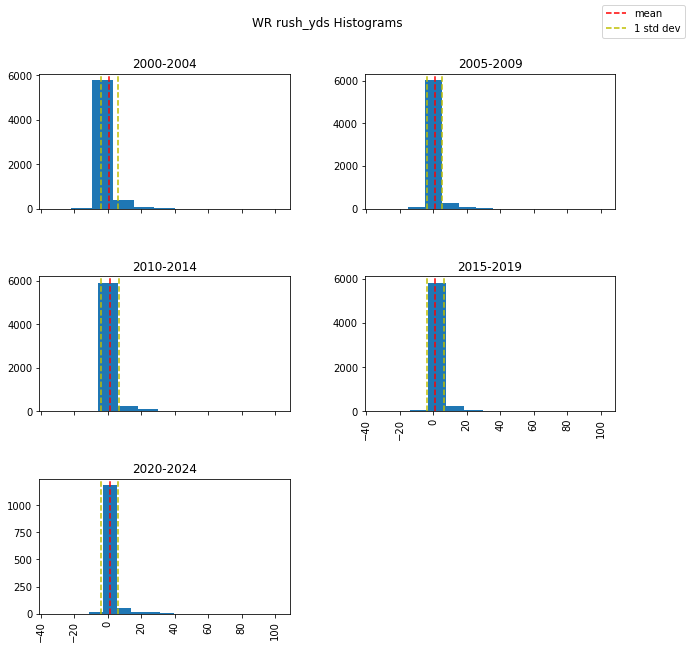

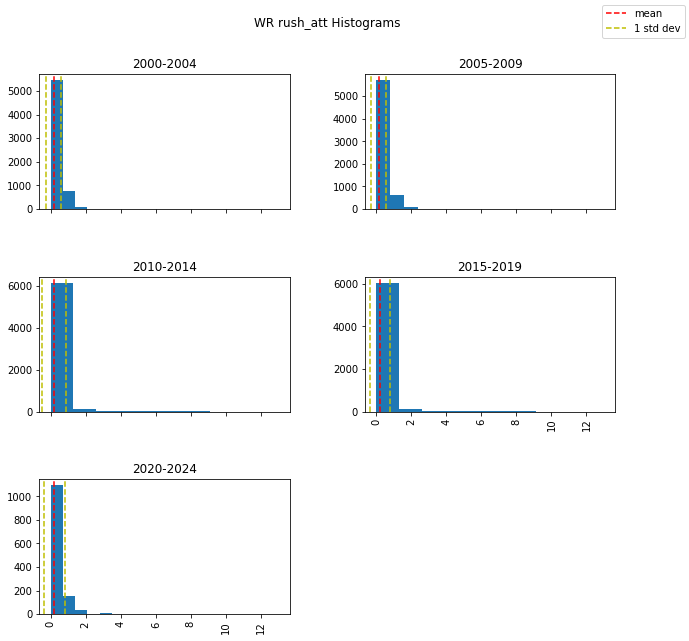

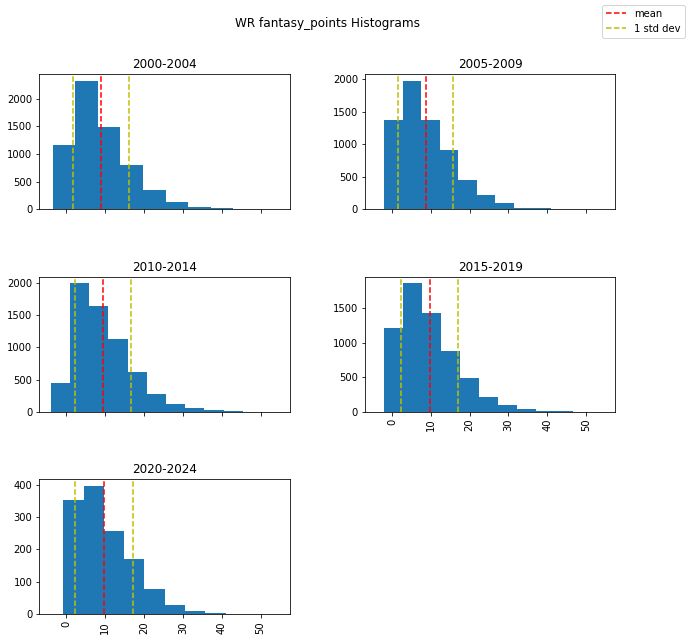

In [25]:
# First visualize data
plot_multiple_yearly_hists(wr_df, 'WR', ['rec_yds', 'rec_td', 'rec', 'rush_yds', 'rush_att', 'fantasy_points'],
                          histby='5years')

For WR we can see that the results are much more uniform across years. It's interesting that the wide receivers have held relatively constant performance while the QB's stats have changed so much. We may be able to get a sense of why this is by looking at the games grouped by player. Let's quickly look at this.

In [26]:
player_means, player_stds = player_stat_grouping(wr_df, relevant_stats)
player_means = player_means.reset_index()
player_means.loc[:, 'pos'] = player_means.apply(lambda row: row.unique_id.split(',')[2], axis=1)
player_means.loc[:, 'year'] = player_means.apply(lambda row: int(row.unique_id.split(',')[3]), axis=1)
player_means.loc[:, '5years'] = player_means.apply(lambda row: str(row.year // 5 * 5) + '-' + str(row.year // 5 * 5 + 4), axis=1)

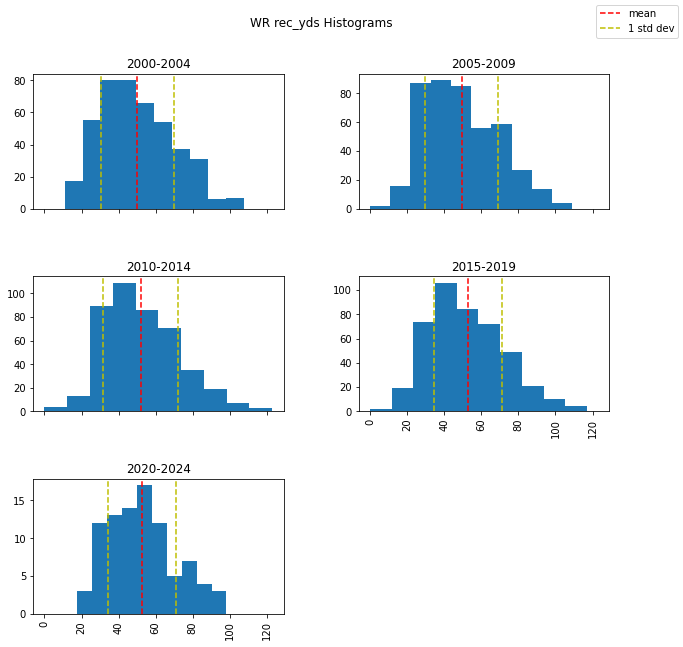

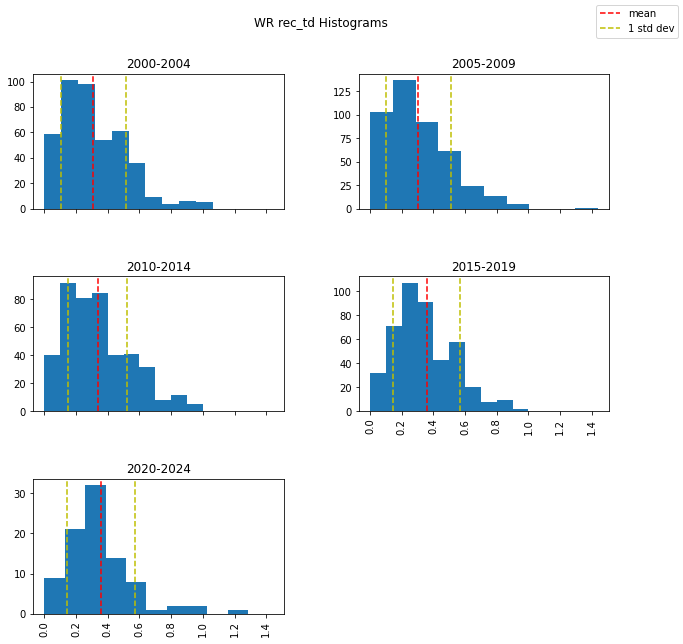

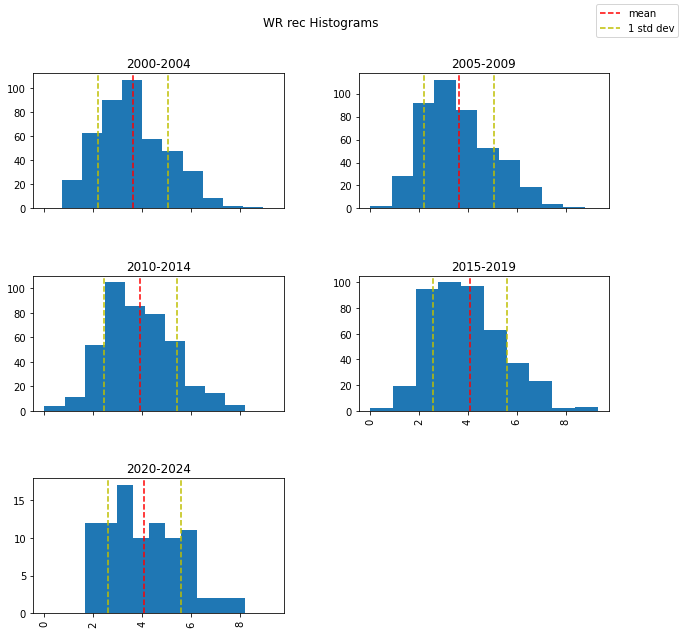

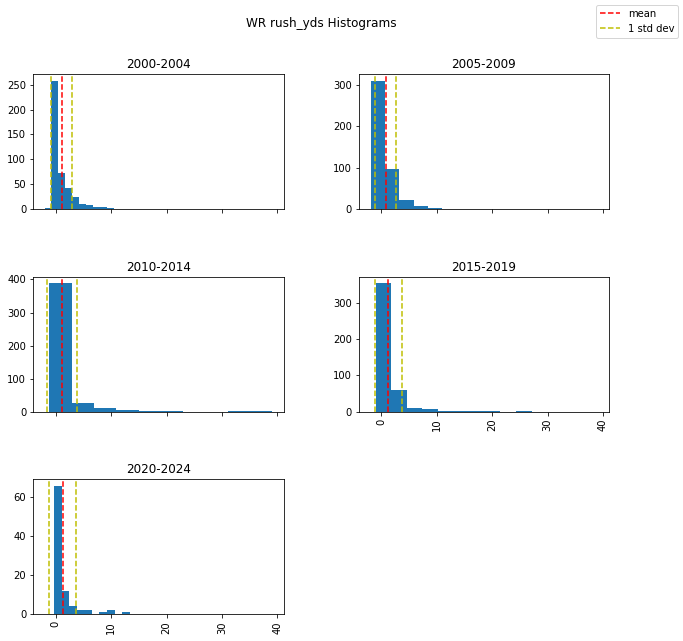

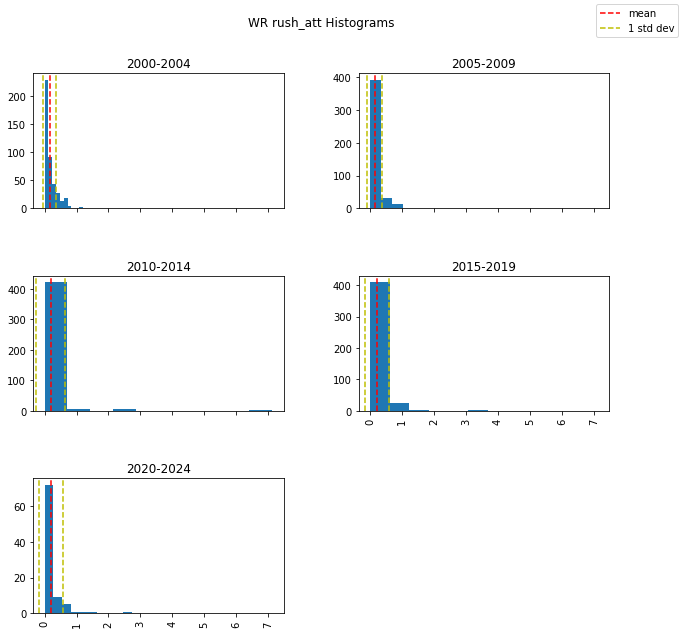

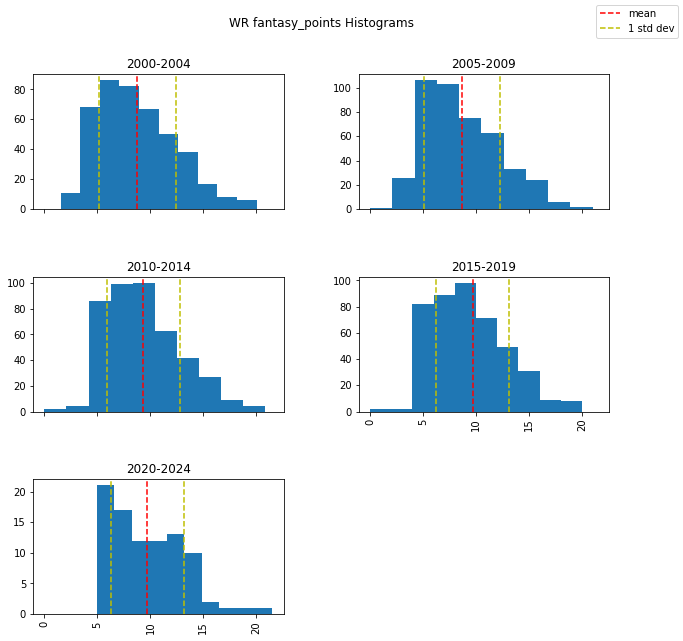

In [27]:
plot_multiple_yearly_hists(player_means, 'WR', ['rec_yds', 'rec_td', 'rec', 'rush_yds', 'rush_att', 'fantasy_points'],
                          histby='5years')

In [28]:
years = np.array([year for year in range(2000, 2021)])

In [29]:
create_year_lambda = lambda year: (lambda df: df['year'] == year)
yearly_splits = [create_year_lambda(year) for year in years]
split_results_yearly = compare_splits(RandomForestClassifier(n_jobs=-1), wr_df, yearly_splits, input_vars=relevant_stats)

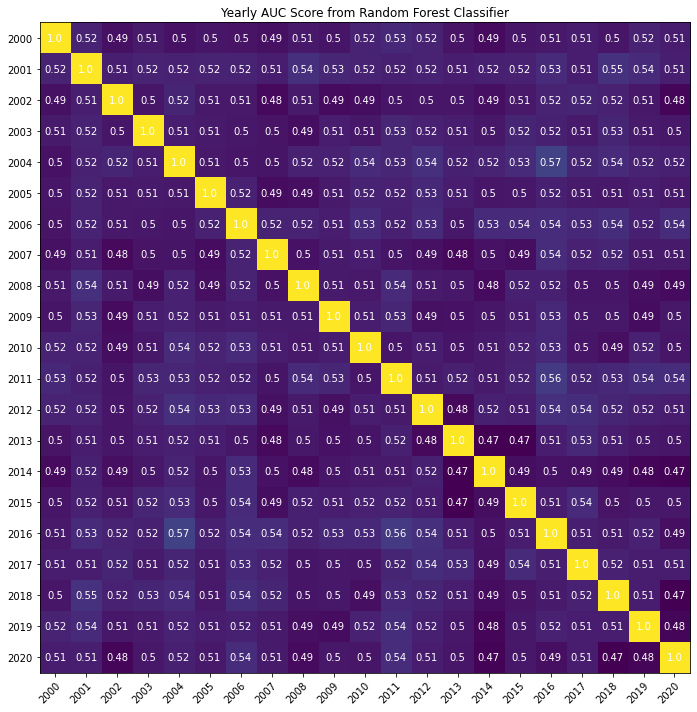

In [30]:
heatmap(split_results_yearly, years, years, 'Yearly AUC Score from Random Forest Classifier')

/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan, 0.5051669086328819, 0.5070304682810381, 0.5075169135489007, 0.5100809687597643, 0.510592152118234, 0.5102927243685195, 0.5130456121432841, 0.5146899359162435, 0.5162267853612924, 0.5113538750844597, 0.5160376803759544, 0.5183755137099103, 0.5116486223847967, 0.5168028273323088, 0.5189278510072307, 0.5122861482796397, 0.5168293508552423, 0.5053106757467185, 0.5175641911513523, 0.5122901680578029]


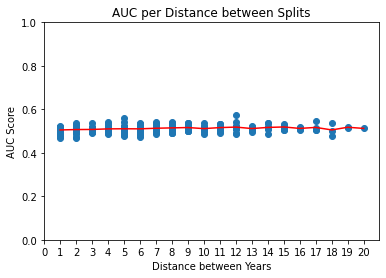

In [31]:
auc_distance_scatter(split_results_yearly, 'AUC per Distance between Splits')

As expected the WR class did not shift enough over the years for past years to be distinct such that earlier years should serve as a similar enough dataset to be beneficial for our model. Let's just check over remaining positions to see if the same holds true.

In [32]:
player_split_results_yearly = compare_splits(RandomForestClassifier(n_jobs=-1), player_means, yearly_splits, input_vars=relevant_stats)

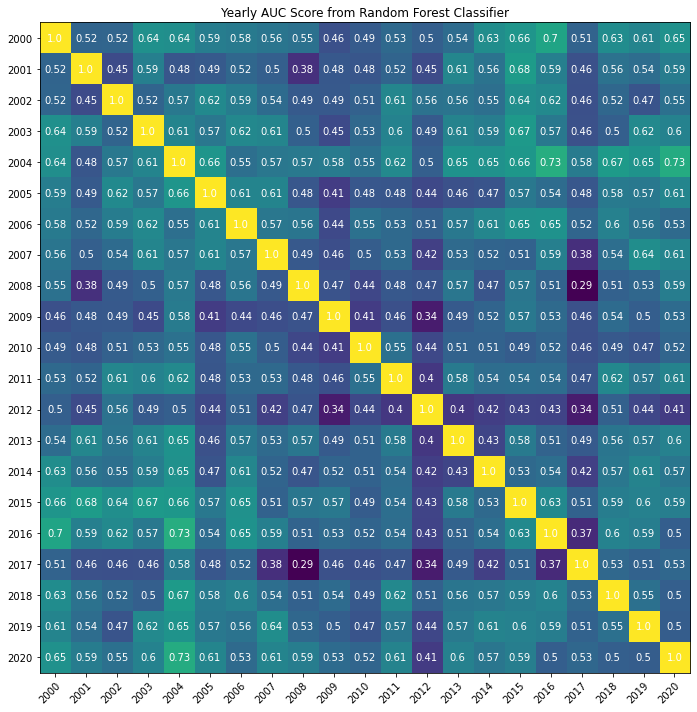

In [33]:
heatmap(player_split_results_yearly, years, years, 'Yearly AUC Score from Random Forest Classifier')

/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[nan, 0.5085032357061544, 0.5269295071440606, 0.5162982153794216, 0.5286555540039479, 0.5241223096260735, 0.5182718705123845, 0.5235565275595077, 0.513382208111451, 0.5253605056429835, 0.5402815804901384, 0.5449397874431736, 0.5965390797405052, 0.579319245749199, 0.5968381061093638, 0.5791518121386218, 0.6075513199567567, 0.5359691819120529, 0.5742044658358854, 0.5967175387596899, 0.648263888888889]


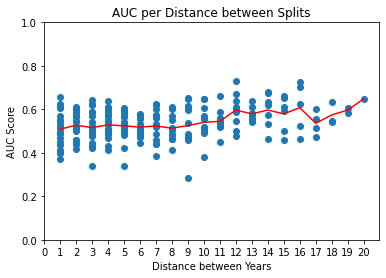

In [34]:
auc_distance_scatter(player_split_results_yearly, 'AUC per Distance between Splits')

As you can see here there is 

### Running Back

In [35]:
# Grab wr data
rb_df = players_df[(players_df['pos'] == 'RB')].reset_index(drop=True)

/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/Caskroom/miniconda/base/envs/cos429/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not lay

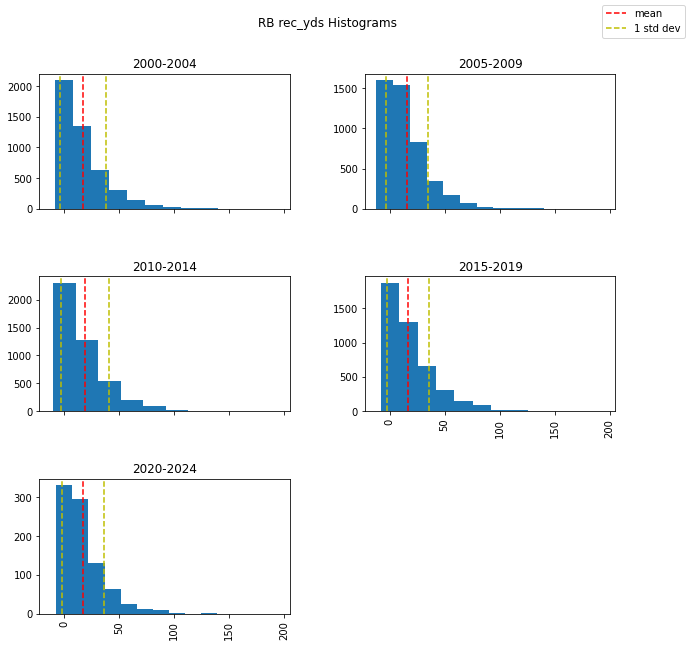

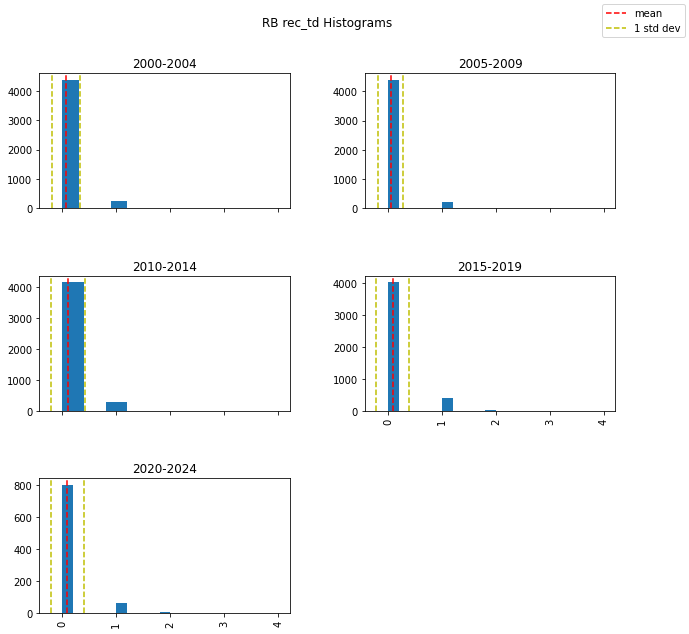

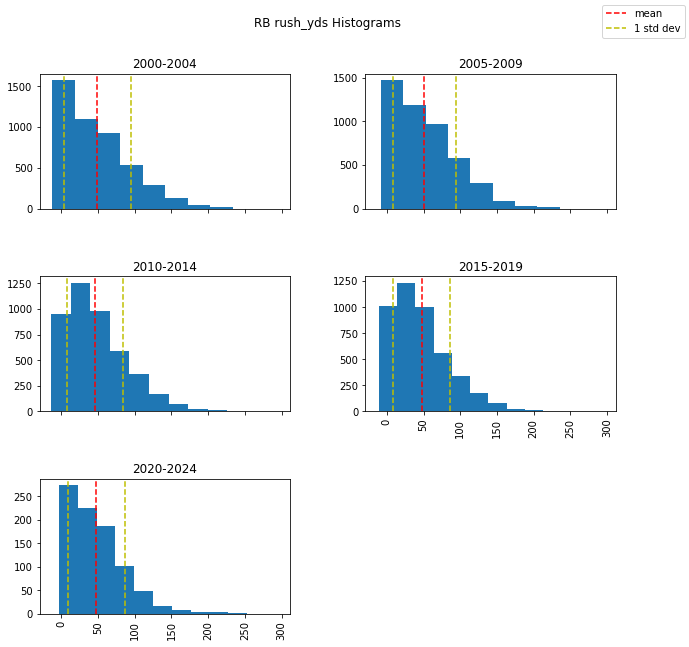

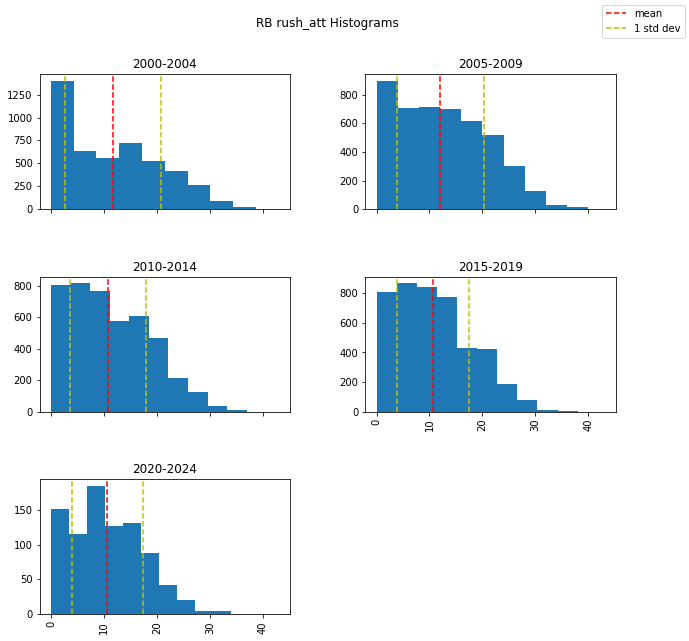

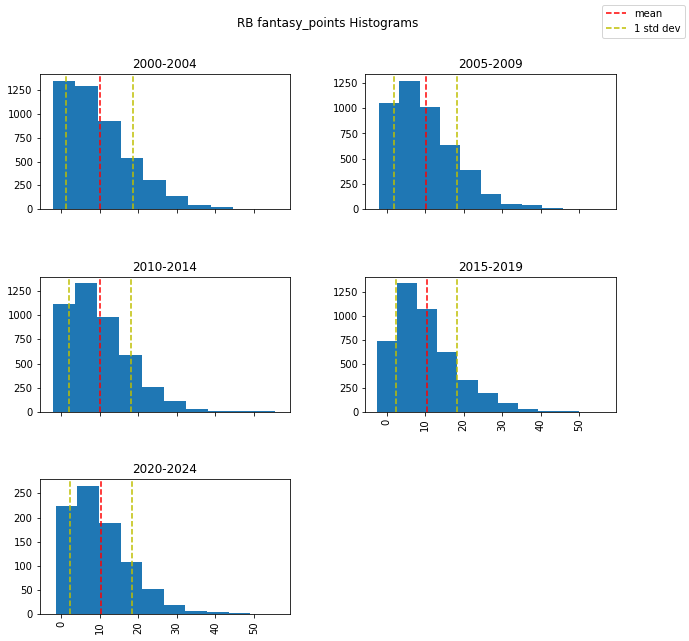

In [36]:
# First visualize data
plot_multiple_yearly_hists(rb_df, 'RB', ['rec_yds', 'rec_td', 'rush_yds', 'rush_att', 'fantasy_points'],
                          histby='5years')

While there is some decrease in the amount of rush attempts over the years as the offense has become more pass focused. This however did not result in 